# SVM, forêts aléatoires, boosting et régression régularisée
## Partie 1 : Discrimination binaire

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(kernlab)))
suppressWarnings(library(caret))
suppressWarnings(library(doParallel))

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Loading required package: foreach

Attaching package: 'foreach'

The following objects are masked from 'package:purrr':

    accumulate, when

Loading required package: iterators
Loading required package: parallel


Importer le jeu de données `spam` du package `kernlab` à l’aide de la commande `data(spam)`. Afficher les informations sur ce jeu de données à l’aide de la commande `help(spam)`, ainsi qu’un résumé de ce jeu de données.  
Séparer le jeu de données en un échantillon d’apprentissage et un échantillon de validation de son choix.

In [2]:
data(spam)
spam <- spam %>% rename(Y = type)
part <- createDataPartition(spam$Y, p = 2/3)
data_train <- spam[part$Resample1,]
data_test <- spam[-part$Resample1,]

Lancer sur l’échantillon d’apprentissage une SVM linéaire en ajustant sa constante de tolérance C par validation croisée 10-fold.

[1] "Test accuracy: 0.923026744944553"

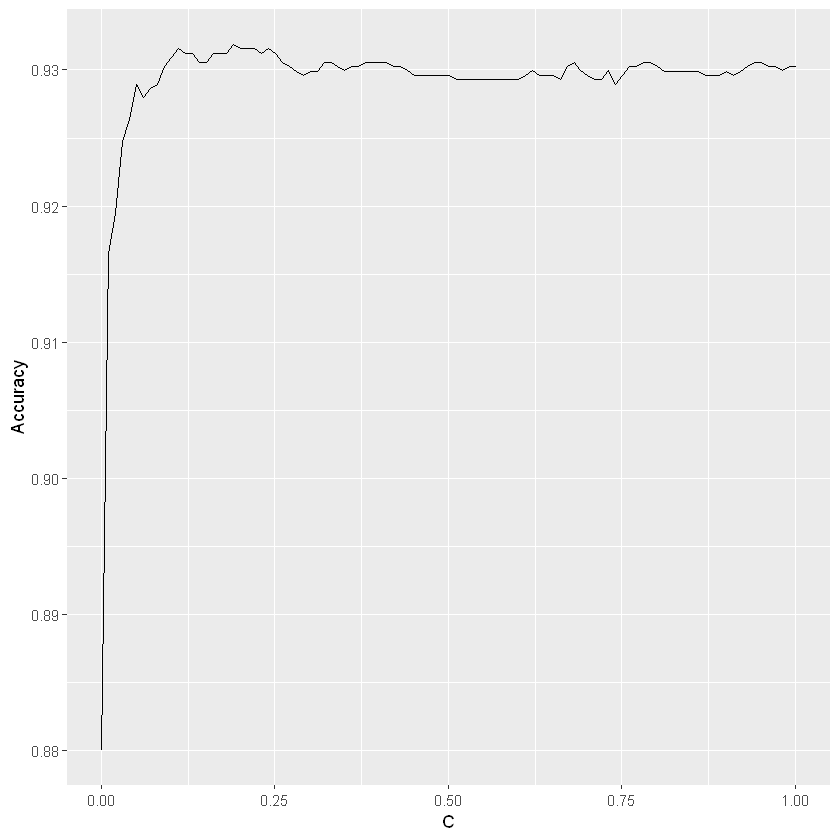

In [3]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

svm_1 <- caret::train(
    Y~., data = data_train, method = 'svmLinear',
    trControl = trainControl("cv", number = 10),
    tuneGrid = expand.grid(C = seq(.001, 1.001, by = .01))
)
on.exit(stopCluster(cl))

ggplot(svm_1$results) +
aes(C, Accuracy) + geom_line()

paste(
    'Test accuracy:',
    1 - mean(predict(svm_1$finalModel, newdata = select(data_test, -Y)) != pull(data_test, Y))
)

Lancer sur l’échantillon d’apprentissage une SVM à noyau gaussien (radial) en ajustant ses paramètres parvalidation croisée 10-fold.

[1] "Test accuracy: 0.863666014350946"

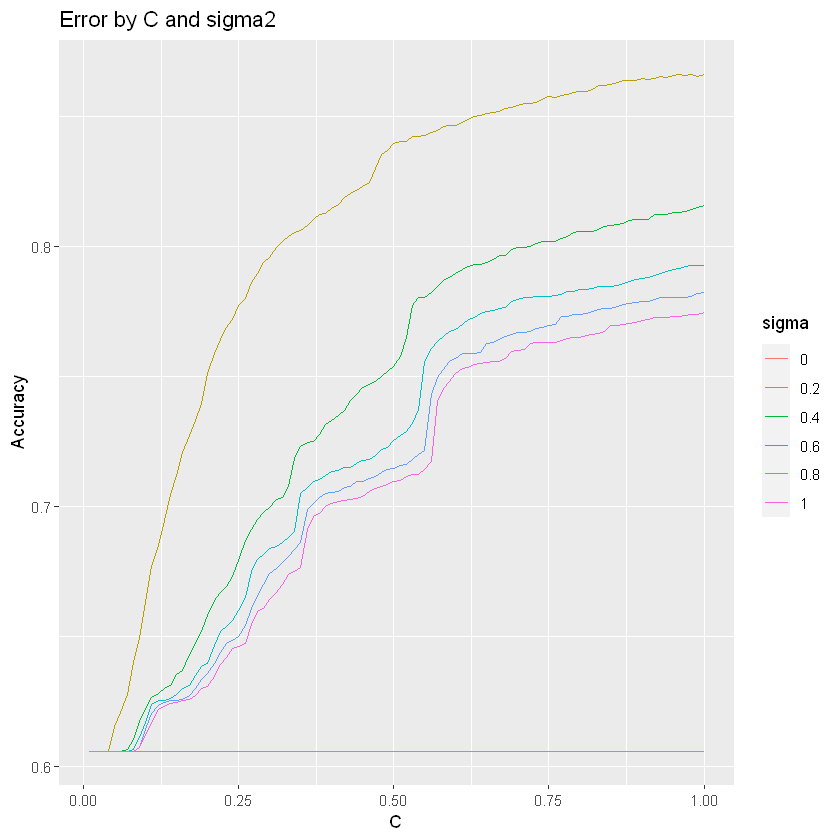

In [4]:
cl <- makePSOCKcluster(10)
registerDoParallel(cl)

svm_2 <- caret::train(
    Y~., data = data_train, method = 'svmRadial',
    trControl = trainControl("cv", number = 10),
    tuneGrid = expand.grid(sigma = seq(0, 1, by = .2), C = seq(.01, 1, by = .01))
)
on.exit(stopCluster(cl))

svm_2$results %>% mutate(sigma = as.factor(sigma)) %>% 
ggplot() + aes(x = C, y = Accuracy, color = sigma) + 
geom_line() +
ggtitle('Error by C and sigma2')

paste(
    'Test accuracy:',
    1 - mean(predict(svm_2$finalModel, newdata = select(data_test, -Y)) != pull(data_test, Y))
)

Lancer sur l’échantillon d’apprentissage un algorithme de forêt aléatoire en ajustant ses paramètres par la méthode Out Of Bag.